## Data Integration, EDA

Some imports, settings

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

def set_options():
    # matplotlib params
    matplotlib.rc_params['figure.figsize'] = [12, 8]
    # seaborn styles
    sns.set_style()

Load the main dataset

In [2]:
df = pd.concat(
    [pd.read_csv('./data/train_features.csv'),
     pd.read_csv('./data/train_targets.csv')],
    axis=1)
df = df.loc[:,~df.columns.duplicated()]

Optimize the memory a bit

In [3]:
# memory usage reduction code from: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
df = reduce_mem_usage(df)

Memory usage of dataframe is 75.41 MB
Memory usage after optimization is: 15.97 MB
Decreased by 78.8%


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39675 entries, 0 to 39674
Columns: 250 entries, match_id_hash to next_roshan_team
dtypes: category(2), float16(31), int16(67), int32(10), int8(140)
memory usage: 16.0 MB


In [5]:
df.nunique()

match_id_hash                 39675
game_time                      3417
game_mode                         8
lobby_type                        2
objectives_len                   43
chat_len                        158
r1_hero_id                      115
r1_kills                         33
r1_deaths                        26
r1_assists                       40
r1_denies                        70
r1_gold                       16407
r1_lh                           504
r1_xp                         17368
r1_health                      2803
r1_max_health                   716
r1_max_mana                    1298
r1_level                         25
r1_x                             62
r1_y                             59
r1_stuns                       4597
r1_creeps_stacked                49
r1_camps_stacked                 14
r1_rune_pickups                  41
r1_firstblood_claimed             2
r1_teamfight_participation      787
r1_towers_killed                  9
r1_roshans_killed           

In [6]:
'The number of missing values is %d. That is roughly %3.2f%% of the values' % (df.isnull().sum().sum(), 
                                                                               df.isnull().sum().sum() / np.prod(df.shape)*100)

'The number of missing values is 14350. That is roughly 0.14% of the values'

#### Let's dive in the extended dataset – the .jsonl file – and other external data to build a dataset of heroes.

Make a mapping for hero names to hero id – inside initial dataset

In [7]:
from tqdm import tqdm_notebook
from collections import OrderedDict
try:
    import ujson as json
except ModuleNotFoundError:
    import json

# Define utility function to iterate through all heroes in a match
def iter_hero_cols(col_desc='hero_id'):
    for c in ['r','d']:
        for i in range(1,6):
            yield f'{c}{i}_{col_desc}'

# First take a look at how many unique hero ID's we can find
unique_heroes = []
for col in iter_hero_cols():
    unique_heroes += df[col].unique().tolist()
hero_count = len(set(unique_heroes))

# Loop through the large JSON until we retrieved 115 hero names!
hero_to_id = {}
id_to_hero = {}
retrieved = 0
done = False
with open('data/train_matches.jsonl') as raw:
    for game in tqdm_notebook(raw, total=df.shape[0]):
        game = json.loads(game)
        for player in game['players']:
            hero_id = player['hero_id']
            hero_name = player['hero_name'][14:].replace('_',' ')
            if not hero_id in id_to_hero:
                retrieved += 1
                id_to_hero[hero_id] = hero_name
                hero_to_id[hero_name] = hero_id
            if retrieved == hero_count:
                done = True
                break
        if done:
            break
            
# Sort the hero mappings
hero_to_id = OrderedDict((key, hero_to_id[key]) for key in sorted(hero_to_id))
id_to_hero = OrderedDict((key, id_to_hero[key]) for key in sorted(id_to_hero))

# Correct the typos in both mappings
hero_to_id['zeus'] = hero_to_id.get('zuus', 'zeus')
if hero_to_id.get('zuus'): del hero_to_id['zuus']

zuus_key = [hero_id for hero_id in id_to_hero.keys() 
                    if id_to_hero[hero_id] == 'zuus']
if zuus_key: id_to_hero[zuus_key[0]] = 'zeus'
    
print('Done')


Done


Initialize the hero dataset.

In [8]:
hero_df = pd.DataFrame(index=id_to_hero.keys())
hero_df['name'] = id_to_hero.values()
hero_df['name_stripped'] = hero_df['name'].str.replace(' ','')
hero_df['stat'] = None
hero_df['types'] = [[] for _ in range(hero_count)]

The ```./data/hero_classes.json``` file was manually scrapped from https://dota2.gamepedia.com/Role on 26 March 2019. <br>
Merge it with our hero data frame.

In [9]:
# Read the hero classes file
f = open('./data/hero_classes.json')
hero_classes = json.load(f)
f.close()

# Define a function to match names between datasets.
alt_names = {'nevermore': 'shadowfiend',
             'windrunner': 'windranger',
             'necrolyte': 'necrophos',
             'skeletonking': 'wraithking',
             'rattletrap': 'clockwerk',
             'furion': 'naturesprophet',
             'obsidiandestroyer': 'outworlddevourer',
             'wisp': 'io',
             'magnataur': 'magnus',
             'shredder': 'timbersaw'}
def is_match(name, out_name):
    out_name = out_name.replace(' ','')\
                       .replace('-','')\
                       .replace("'",'').lower()
    direct_match = (name == out_name) or \
                    name.startswith(out_name) or \
                    name.endswith(out_name) or \
                    out_name.startswith(name) or \
                    out_name.endswith(name)
    alt_name = alt_names.get(name, False)
    
    return direct_match or (alt_name and is_match(alt_name, 
                                                  out_name))

# Get a list of all unique names of the 'external' dataset
external_names = []
for h_class, h_by_stat in hero_classes.items():
    for h_stat, h_list in h_by_stat.items():
        external_names += h_list
external_names = set(external_names)

# Create a mapping between hero names as found in our initial dataset and hero names from the secondary dataset 
external_name_map = {}
for e_name in external_names:
    for _, row in hero_df[['name', 'name_stripped']].iterrows():
        if is_match(row['name_stripped'], e_name):
            external_name_map[e_name] = row['name']
            break

# Check if we cover all the heroes in the 'internal' dataset
assert len(external_name_map) == hero_count

# Lastly, merge the stats in the 'external' dataset with the stats of the 'internal' dataset
hero_df['types'] = [[] for _ in range(hero_count)] # reinitialize column when before filling it up, as we use append to fill it
for h_class, h_by_stat in hero_classes.items():
    for h_stat, h_list in h_by_stat.items():
        for hero in h_list:
            i_name = external_name_map.get(hero)
            if i_name:
                hero_df.loc[hero_to_id[i_name], 'types'].append(h_class)
                hero_df.loc[hero_to_id[i_name], 'stat'] = h_stat
                
hero_df.sample(10) 

,name,name_stripped,stat,types
43,death prophet,deathprophet,int,"[Carry, Nuker, Disabler, Pusher]"
2,axe,axe,str,"[Disabler, Jungler, Durable, Initiator]"
59,huskar,huskar,str,"[Carry, Durable, Initiator]"
71,spirit breaker,spiritbreaker,str,"[Carry, Disabler, Durable, Escape, Initiator]"
56,clinkz,clinkz,agi,"[Carry, Escape, Pusher]"
107,earth spirit,earthspirit,str,"[Nuker, Disabler, Durable, Escape, Initiator]"
114,monkey king,monkeyking,agi,"[Carry, Disabler, Escape, Initiator]"
44,phantom assassin,phantomassassin,agi,"[Carry, Escape]"
54,life stealer,lifestealer,str,"[Carry, Disabler, Jungler, Durable, Escape]"
112,winter wyvern,winterwyvern,int,"[Support, Nuker, Disabler]"


We can also derive a new feature, ```num_types``` as the number of roles the hero can take.

In [10]:
hero_df['num_types'] = hero_df['types'].map(set).map(len)
hero_df.sample(10)

,name,name_stripped,stat,types,num_types
83,treant,treant,str,"[Support, Disabler, Durable, Escape, Initiator]",5
109,terrorblade,terrorblade,agi,"[Carry, Nuker, Pusher]",3
36,necrolyte,necrolyte,int,"[Carry, Nuker, Disabler, Durable]",4
46,templar assassin,templarassassin,agi,"[Carry, Escape]",2
20,vengefulspirit,vengefulspirit,agi,"[Support, Nuker, Disabler, Escape, Initiator]",5
110,phoenix,phoenix,str,"[Support, Nuker, Disabler, Escape, Initiator]",5
94,medusa,medusa,agi,"[Carry, Disabler, Durable]",3
30,witch doctor,witchdoctor,int,"[Support, Nuker, Disabler]",3
11,nevermore,nevermore,agi,"[Carry, Nuker]",2
120,pangolier,pangolier,agi,"[Carry, Nuker, Disabler, Durable, Escape, Init...",6


Try to also merge with actual hero stat values from https://devilesk.com/dota2/heroes/herodata/

In [11]:
# Load the spreadsheet and preview
hero_stats = pd.read_csv('data/hero_stats.csv')
hero_stats.info()
hero_stats.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 33 columns):
name                         116 non-null object
agi                          116 non-null int64
agi_gain                     116 non-null float64
int                          116 non-null int64
int_gain                     116 non-null float64
str                          116 non-null int64
str_gain                     116 non-null float64
hp                           116 non-null int64
hp_regen                     116 non-null float64
mana                         116 non-null int64
mana_regen                   116 non-null float64
armor                        116 non-null float64
damage_reduction             116 non-null float64
movespeed                    116 non-null float64
turn_rate                    116 non-null float64
mean_base_damage             116 non-null float64
min_base_damage              116 non-null int64
max_base_damage              116 non-null int64
status_res

,name,agi,agi_gain,int,int_gain,str,str_gain,hp,hp_regen,mana,...,atk_time,atk_per_sec,atk_point,projectile_speed,physical_effective_health,magical_effective_health,range,vision_day,vision_night,dps
44,Legion Commander,18,1.7,20,2.2,26,2.9,720,1.78,315,...,1.44,0.69,0.46,900,792.0,960.00,150,1800,800,43.47
20,Dark Seer,12,1.2,21,2.7,24,2.9,680,1.76,327,...,1.52,0.66,0.59,900,918.0,878.98,150,1800,800,37.62
64,Outworld Devourer,24,2.0,24,2.7,19,2.6,580,1.70,363,...,1.37,0.73,0.46,900,710.5,746.46,450,1800,800,34.67
75,Queen of Pain,18,2.0,22,2.5,18,2.3,560,1.69,339,...,1.27,0.79,0.56,1500,616.0,722.81,550,1800,800,38.71
59,Naga Siren,21,3.2,21,2.0,22,2.8,640,3.47,327,...,1.40,0.71,0.50,900,848.0,853.33,150,1800,800,31.95


In [12]:
# Make a quick check to see if we can match all heroes based on the previous function
for i_name in hero_df['name_stripped']:
    for e_name in hero_stats['name']:
        if is_match(i_name, e_name):
            break
    else:
        print(f'{i_name} unmatched :(')

All hero names can be matched, great.

In [13]:
# Given hero name, get corresponding index of original dataframe
def get_index(e_name):
    matcher = lambda i_name: is_match(i_name, e_name)
    try:
        return hero_df[hero_df['name_stripped'].apply(matcher)].index.item()
    except ValueError:
        return None
    
# Reindex the stats dataframe for easy merging
hero_stats['other_index'] = hero_stats['name'].map(get_index)
hero_stats = hero_stats.dropna()
hero_stats['other_index'] = hero_stats['other_index'].astype(int)
hero_stats = hero_stats.set_index('other_index').sort_index()

Finally, merge all the hero information together.

In [14]:
heroes = hero_df.join(hero_stats.drop(columns='name'))

In [15]:
heroes.sort_values('dps', ascending=False).head()

,name,name_stripped,stat,types,num_types,agi,agi_gain,int,int_gain,str,...,atk_time,atk_per_sec,atk_point,projectile_speed,physical_effective_health,magical_effective_health,range,vision_day,vision_night,dps
83,treant,treant,str,"[Support, Disabler, Durable, Escape, Initiator]",5,15,2.0,20,1.8,25,...,1.65,0.61,0.6,900,717.50,933.33,150,1800,800,55.51
27,shadow shaman,shadowshaman,int,"[Support, Nuker, Disabler, Pusher, Initiator]",5,16,1.6,21,3.0,23,...,1.47,0.68,0.3,900,781.00,853.13,400,1800,800,52.02
12,phantom lancer,phantomlancer,agi,"[Carry, Nuker, Escape, Pusher]",4,29,2.8,19,2.0,19,...,1.32,0.76,0.5,900,720.17,773.33,150,1800,800,47.12
1,antimage,antimage,agi,"[Carry, Nuker, Escape]",3,22,2.8,12,1.8,23,...,1.15,0.87,0.3,0,748.00,880.00,150,1800,800,46.11
38,beastmaster,beastmaster,str,"[Nuker, Disabler, Durable, Initiator]",4,18,1.6,16,1.9,23,...,1.44,0.69,0.3,0,726.00,880.00,150,1800,800,45.54


### Generating some hero statistics from our data

In [16]:
hero_statistics = pd.DataFrame(heroes['name'])
hero_statistics['hero_id'] = hero_statistics['name'].map(hero_to_id.get)
hero_statistics.head()

,name,hero_id
1,antimage,1
2,axe,2
3,bane,3
4,bloodseeker,4
5,crystal maiden,5


In [17]:
def get_stat_data(hero_id, stat):
    all_data = pd.Series()
    for col_head in iter_hero_cols(col_desc=''):
        hero_id_col = col_head + 'hero_id'
        hero_filter = (df[hero_id_col] == hero_id)
        hero_stat = col_head + stat
        all_data = pd.concat([all_data, df.loc[hero_filter, hero_stat]],
                             ignore_index=True)
    return all_data

In [18]:
get_stat_data(hero_to_id['sven'], 'gold').describe()  ## pd.Series

count     3293.000000
mean      9193.671121
std       7932.136180
min         26.000000
25%       2894.000000
50%       7166.000000
75%      13435.000000
max      53878.000000
dtype: float64

In [19]:
def get_player_features():
    with open('data/train_matches.jsonl') as raw:
        for game in tqdm_notebook(raw, total=df.shape[0]):
            game = json.loads(game)
            return game['players'][0].keys()

sentinel = ["sen"+str(i) for i in range(1,6)]
scourge = ["srg"+str(i) for i in range(1,6)]
        
def construct_frame(features = ['hero_name','hero_id','kills','deaths','assists','gold_t']):
    clipped_jsonl = []
    with open('data/train_matches.jsonl') as raw:
        for game in tqdm_notebook(raw, total=df.shape[0]):
            gameson = {}
            game = json.loads(game)
            gameson['win'] = game['targets']['radiant_win']
            sentinel_p = []
            scourge_p = []
            for j in range(0,len(game['players'])):
                p = game['players'][j]
                if j<5:
                    sentinel_p.append({k : p[k] for k in features})
                else:
                    scourge_p.append({k : p[k] for k in features})
            for j in range(0,len(sentinel)):
                gameson[scourge[j]] = scourge_p[j]  
                gameson[sentinel[j]] = sentinel_p[j]
            clipped_jsonl.append(gameson)
        return clipped_jsonl

jsonl = construct_frame()

In [20]:
match_df = pd.read_json(json.dumps(jsonl))
match_df.head(10)

,sen1,sen2,sen3,sen4,sen5,srg1,srg2,srg3,srg4,srg5,win
0,"{'hero_name': 'npc_dota_hero_nevermore', 'hero...","{'hero_name': 'npc_dota_hero_brewmaster', 'her...","{'hero_name': 'npc_dota_hero_pudge', 'hero_id'...","{'hero_name': 'npc_dota_hero_huskar', 'hero_id...","{'hero_name': 'npc_dota_hero_lycan', 'hero_id'...","{'hero_name': 'npc_dota_hero_phantom_lancer', ...","{'hero_name': 'npc_dota_hero_windrunner', 'her...","{'hero_name': 'npc_dota_hero_night_stalker', '...","{'hero_name': 'npc_dota_hero_ogre_magi', 'hero...","{'hero_name': 'npc_dota_hero_tinker', 'hero_id...",False
1,"{'hero_name': 'npc_dota_hero_razor', 'hero_id'...","{'hero_name': 'npc_dota_hero_centaur', 'hero_i...","{'hero_name': 'npc_dota_hero_shadow_shaman', '...","{'hero_name': 'npc_dota_hero_weaver', 'hero_id...","{'hero_name': 'npc_dota_hero_naga_siren', 'her...","{'hero_name': 'npc_dota_hero_enchantress', 'he...","{'hero_name': 'npc_dota_hero_pudge', 'hero_id'...","{'hero_name': 'npc_dota_hero_antimage', 'hero_...","{'hero_name': 'npc_dota_hero_clinkz', 'hero_id...","{'hero_name': 'npc_dota_hero_visage', 'hero_id...",True
2,"{'hero_name': 'npc_dota_hero_skywrath_mage', '...","{'hero_name': 'npc_dota_hero_rattletrap', 'her...",{'hero_name': 'npc_dota_hero_phantom_assassin'...,"{'hero_name': 'npc_dota_hero_dragon_knight', '...","{'hero_name': 'npc_dota_hero_furion', 'hero_id...","{'hero_name': 'npc_dota_hero_sven', 'hero_id':...","{'hero_name': 'npc_dota_hero_spectre', 'hero_i...","{'hero_name': 'npc_dota_hero_viper', 'hero_id'...","{'hero_name': 'npc_dota_hero_venomancer', 'her...","{'hero_name': 'npc_dota_hero_storm_spirit', 'h...",True
3,"{'hero_name': 'npc_dota_hero_pudge', 'hero_id'...","{'hero_name': 'npc_dota_hero_bristleback', 'he...","{'hero_name': 'npc_dota_hero_skywrath_mage', '...","{'hero_name': 'npc_dota_hero_lion', 'hero_id':...","{'hero_name': 'npc_dota_hero_faceless_void', '...","{'hero_name': 'npc_dota_hero_sven', 'hero_id':...","{'hero_name': 'npc_dota_hero_shredder', 'hero_...","{'hero_name': 'npc_dota_hero_juggernaut', 'her...","{'hero_name': 'npc_dota_hero_doom_bringer', 'h...","{'hero_name': 'npc_dota_hero_rubick', 'hero_id...",True
4,"{'hero_name': 'npc_dota_hero_skeleton_king', '...","{'hero_name': 'npc_dota_hero_doom_bringer', 'h...","{'hero_name': 'npc_dota_hero_shadow_shaman', '...",{'hero_name': 'npc_dota_hero_legion_commander'...,"{'hero_name': 'npc_dota_hero_batrider', 'hero_...","{'hero_name': 'npc_dota_hero_kunkka', 'hero_id...","{'hero_name': 'npc_dota_hero_zuus', 'hero_id':...","{'hero_name': 'npc_dota_hero_sniper', 'hero_id...","{'hero_name': 'npc_dota_hero_gyrocopter', 'her...","{'hero_name': 'npc_dota_hero_antimage', 'hero_...",False
5,"{'hero_name': 'npc_dota_hero_omniknight', 'her...","{'hero_name': 'npc_dota_hero_morphling', 'hero...","{'hero_name': 'npc_dota_hero_chaos_knight', 'h...","{'hero_name': 'npc_dota_hero_shredder', 'hero_...","{'hero_name': 'npc_dota_hero_dark_willow', 'he...","{'hero_name': 'npc_dota_hero_luna', 'hero_id':...",{'hero_name': 'npc_dota_hero_ancient_apparitio...,"{'hero_name': 'npc_dota_hero_night_stalker', '...","{'hero_name': 'npc_dota_hero_abaddon', 'hero_i...","{'hero_name': 'npc_dota_hero_juggernaut', 'her...",False
6,"{'hero_name': 'npc_dota_hero_dark_willow', 'he...","{'hero_name': 'npc_dota_hero_spirit_breaker', ...",{'hero_name': 'npc_dota_hero_phantom_assassin'...,"{'hero_name': 'npc_dota_hero_sniper', 'hero_id...",{'hero_name': 'npc_dota_hero_abyssal_underlord...,"{'hero_name': 'npc_dota_hero_viper', 'hero_id'...","{'hero_name': 'npc_dota_hero_shredder', 'hero_...","{'hero_name': 'npc_dota_hero_lion', 'hero_id':...",{'hero_name': 'npc_dota_hero_legion_commander'...,{'hero_name': 'npc_dota_hero_keeper_of_the_lig...,True
7,"{'hero_name': 'npc_dota_hero_phantom_lancer', ...","{'hero_name': 'npc_dota_hero_dragon_knight', '...","{'hero_name': 'npc_dota_hero_wisp', 'hero_id':...","{'hero_name': 'npc_dota_hero_monkey_king', 'he...","{'hero_name': 'npc_dota_hero_dazzle', 'hero_id...","{'he

In [21]:
def hero_to_stat(id,stat):
    stat = heroes.loc[id,:][stat]
    if type(stat) is list:
        return stat[np.random.randint(0, len(stat))]
    else:
        return stat

def htos_conv(ls,stat):
    c = []
    for l in ls:
        if type(l) is int:
            c.append(hero_to_stat(l,stat))
        else:
            c.append(hero_to_stat(int(l,stat)))
    return c

def create_sort_hash(column_name, base_column ,hero_stat, hash=True):
    match_stats[column_name] = match_stats[base_column].apply(lambda x : htos_conv(x,hero_stat))
    match_stats[column_name].apply(lambda l: l.sort())
    if hash:
        match_stats[column_name] = match_stats[column_name].apply(lambda l: ";".join(l))

def create_teams():
    #extract, sort ids
    match_df['radiant'] = match_df.apply(lambda row: [row[s]['hero_id'] for s in sentinel] ,axis=1)
    match_df['dire'] = match_df.apply(lambda row: [row[s]['hero_id'] for s in scourge] ,axis=1)
    match_df['radiant'].apply(lambda l: l.sort())
    match_df['dire'].apply(lambda l: l.sort())

def mine(stat,hash=True):
    create_sort_hash(stat,'radiant',stat,hash)
    
def sum_stats():
    match_stats['agis'] = match_stats['agi'].apply(sum)
    match_stats['ints'] = match_stats['int'].apply(sum)
    match_stats['strs'] = match_stats['str'].apply(sum)

create_teams()
match_stats = pd.DataFrame(match_df[['win','radiant']])
for i in ['stat','types']:
    mine(i)
for i in ['agi','int','str']:
    mine(i,hash=False)
sum_stats()
match_stats.head(10)

,win,radiant,stat,types,agi,int,str,agis,ints,strs
0,False,"[11, 14, 59, 77, 78]",agi;str;str;str;str,Carry;Carry;Durable;Initiator;Initiator,"[14, 15, 16, 20, 22]","[14, 14, 17, 18, 18]","[16, 21, 23, 25, 25]",87,81,110
1,True,"[15, 27, 63, 89, 96]",agi;agi;agi;int;str,Carry;Carry;Initiator;Initiator;Nuker,"[14, 15, 16, 21, 22]","[15, 15, 21, 21, 21]","[16, 22, 22, 23, 27]",88,93,110
2,True,"[44, 49, 51, 53, 101]",agi;int;int;str;str,Carry;Carry;Disabler;Durable;Durable,"[13, 13, 18, 19, 23]","[15, 15, 17, 23, 25]","[19, 21, 21, 21, 26]",86,95,108
3,True,"[14, 26, 41, 99, 101]",agi;int;int;str;str,Carry;Carry;Durable;Nuker;Support,"[13, 14, 15, 17, 23]","[14, 14, 15, 18, 25]","[18, 21, 22, 24, 25]",82,86,110
4,False,"[27, 42, 65, 69, 104]",int;int;str;str;str,Disabler;Disabler;Disabler;Durable;Nuker,"[11, 15, 16, 18, 18]","[15, 18, 20, 21, 22]","[22, 23, 26, 26, 28]",78,96,125
5,False,"[10, 57, 81, 98, 119]",agi;int;str;str;str,Disabler;Escape;Initiator;Nuker;Support,"[14, 15, 16, 18, 24]","[13, 15, 18, 18, 21]","[20, 20, 21, 22, 22]",87,85,105
6,True,"[35, 44, 71, 108, 119]",agi;agi;int;str;str,Carry;Durable;Nuker;Nuker;Nuker,"[12, 17, 18, 21, 23]","[14, 15, 15, 17, 18]","[17, 20, 21, 25, 29]",91,79,112
7,False,"[12, 49, 50, 91, 114]",agi;agi;int;str;str,Disabler;Disabler;Durable;Nuker;Support,"[14, 19, 21, 22, 29]","[15, 19, 20, 23, 25]","[17, 18, 19, 19, 19]",105,102,92
8,False,"[14, 23, 49, 74, 93]",agi;int;str;str;str,Carry;Carry;Nuker;Nuker;Nuker,"[14, 14, 14, 19, 21]","[14, 14, 15, 16, 18]","[18, 19, 21, 24, 25]",82,77,107
9,False,"[3, 11, 42, 71, 84]",agi;int;int;str;str,Carry;Initiator;Initiator;Nuker;Support,"[14, 17, 18, 20, 23]","[14, 15, 18, 18, 23]","[16, 22, 23, 25, 29]",92,88,115


In [22]:
#get a winframe based on class
count = match_stats.loc[match_stats['win']]['radiant'].count()
match_stats.loc[match_stats['win']].groupby('stat').count().sort_values('radiant',ascending=False)['radiant'].apply(lambda r: str(r/count*100)+"%")

stat
agi;agi;int;int;str      17.156439066551428%
agi;int;int;str;str      15.869586094305197%
agi;agi;int;str;str      15.831172572745606%
agi;agi;agi;int;str      10.573321809276866%
agi;int;int;int;str        8.33093248823586%
agi;int;str;str;str       7.116104868913857%
agi;agi;agi;int;int       4.292711034284068%
agi;agi;int;int;int       3.534043983482186%
agi;agi;agi;str;str      3.2123307404206285%
int;int;str;str;str      3.1162969365216555%
agi;agi;str;str;str      2.6361279170267933%
int;int;int;str;str      2.1511572073369827%
agi;agi;agi;agi;int      1.5941611447229425%
agi;agi;agi;agi;str      1.3972918467300488%
agi;str;str;str;str      0.9075194468452896%
int;str;str;str;str      0.8979160664553922%
agi;int;int;int;int      0.7394602900220878%
int;int;int;int;str      0.3505233842312494%
agi;agi;agi;agi;agi     0.18246422740804763%
str;str;str;str;str     0.07682704311917794%
int;int;int;int;int    0.033611831364640354%
Name: radiant, dtype: object

In [23]:
#get a winframe based on role
match_stats.loc[match_stats['win']].groupby('types').count().sort_values('radiant',ascending=False)['radiant']

types
Carry;Disabler;Initiator;Nuker;Nuker              192
Carry;Disabler;Escape;Nuker;Nuker                 176
Carry;Disabler;Durable;Nuker;Nuker                167
Carry;Disabler;Escape;Nuker;Support               163
Carry;Disabler;Disabler;Escape;Nuker              161
Carry;Disabler;Escape;Initiator;Nuker             157
Carry;Disabler;Durable;Escape;Nuker               157
Carry;Disabler;Durable;Initiator;Nuker            147
Carry;Disabler;Nuker;Nuker;Support                137
Carry;Disabler;Disabler;Initiator;Nuker           135
Carry;Disabler;Initiator;Nuker;Support            131
Carry;Carry;Disabler;Nuker;Support                128
Carry;Carry;Disabler;Nuker;Nuker                  126
Carry;Disabler;Disabler;Nuker;Nuker               124
Carry;Carry;Disabler;Initiator;Nuker              124
Carry;Carry;Disabler;Escape;Nuker                 123
Carry;Carry;Disabler;Disabler;Nuker               119
Carry;Disabler;Disabler;Durable;Nuker             117
Carry;Disabler;Nuker;N

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003DE83518>,
      dtype=object)

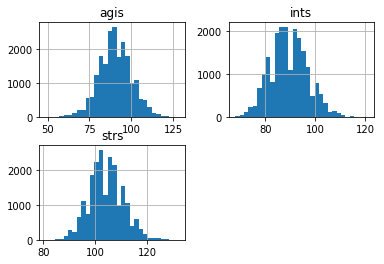

In [24]:
match_stats.loc[match_stats['win']][['agis','ints','strs']].hist(bins=30)